<a href="https://colab.research.google.com/github/abecode/teaching_reviews/blob/main/notebook/teachingReviews_NaiveBayesAndBert_allAnnotators.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intro

For more info see these previous notebooks

- [notebook just using my annotations doing BERT and Naive Bayes](https://colab.research.google.com/drive/1gU8m6UYk32jRex7pqAxtYvBCdq7hfrO7)
- [notebook from Jenny using other annotations](https://colab.research.google.com/drive/11Zsrvud0zrS-07_0TK79wl2T9DLz-wY6)

I'm not sure why Jenny didn't combine all the annotators, but I'm going to do that here and go further with to analyze the attention layers in the BERT model

[cf NLP With Transformers book ch. 9](https://github.com/nlp-with-transformers/notebooks/blob/main/09_few-to-no-labels.ipynb)

## Get Annotations

In [1]:
# install github library from pip
! pip uninstall -y teaching_reviews
! pip install git+https://github.com/abecode/teaching_reviews

  Cloning https://github.com/abecode/teaching_reviews to /tmp/pip-req-build-s_b9sfx6
  Running command git clone --filter=blob:none --quiet https://github.com/abecode/teaching_reviews /tmp/pip-req-build-s_b9sfx6
  Resolved https://github.com/abecode/teaching_reviews to commit 59b1903b5b724caab6c2b6fea11bce81679ed30a
  Preparing metadata (setup.py) ... done
  Created wheel for teaching_reviews: filename=teaching_reviews-0.0.1-py3-none-any.whl size=423896 sha256=19b74d0dc40199c69fead8bcbb125fd5c5e66a7c850c66cadd71bfc62c010e99
  Stored in directory: /tmp/pip-ephem-wheel-cache-3zlggzul/wheels/68/fc/d8/0e3a405d697a0f7f800c691b7af40e458ad838b574c31cc23f
Successfully built teaching_reviews


In [2]:
from teaching_reviews.data import (get_current_annotation_db_connection,
                                   get_sentence_annotation_pivot_df)

In [3]:
df = get_sentence_annotation_pivot_df(get_current_annotation_db_connection())
df.head()

annotator,task_hash,text,abe,jenny,mengyuan,sakthi
0,-2140654332,The lectures did not match up with what was ne...,[NEGATIVE],[NEGATIVE],[NEGATIVE],[NEGATIVE]
1,-2139749861,It is apparent he does not look at the slides ...,[NEGATIVE],[NEGATIVE],[NEGATIVE],"[NEUTRAL, MIXED, NEGATIVE]"
2,-2138139217,"In general, his lectures are pretty dull and h...",[NEGATIVE],[NEGATIVE],[NEGATIVE],[NEGATIVE]
3,-2136947395,He takes attention to what his students sugges...,[POSITIVE],[POSITIVE],[POSITIVE],[POSITIVE]
4,-2127936027,I look forward to seeing how his teaching meth...,[POSITIVE],[POSITIVE],[POSITIVE],[POSITIVE]


In [4]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
label_list_df = (df['abe'] + df['mengyuan'] + df['sakthi'] + df['jenny']).explode().unique()
label_list_df

array(['NEGATIVE', 'NEUTRAL', 'MIXED', 'POSITIVE', 'UNSURE', 'SUGGESTION'],
      dtype=object)

In [5]:
mlb.fit([label_list_df])

MultiLabelBinarizer()

In [6]:
# test out the multilabel binarizer
mlb.transform([["MIXED", "POSITIVE", "NEUTRAL"],["UNSURE", "SUGGESTION"]])

array([[1, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1]])

In [7]:
mlb.inverse_transform(mlb.transform([["MIXED", "POSITIVE", "NEUTRAL"],["UNSURE", "SUGGESTION"]]))

[('MIXED', 'NEUTRAL', 'POSITIVE'), ('SUGGESTION', 'UNSURE')]

## data partitioning

In [8]:
! pip install scikit-multilearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 8.3 MB/s eta 0:00:00


In [9]:
from skmultilearn.model_selection import iterative_train_test_split
import numpy as np

In [10]:
def balanced_split(df, test_size=0.5):
  idx = np.expand_dims(np.arange(len(df)), axis=1)
  labels = mlb.transform(df['labels'])
  train_idx, _, test_idx, _ = iterative_train_test_split(idx, labels, test_size=test_size)
  return df.iloc[train_idx[:, 0]], df.iloc[test_idx[:, 0]]

In [11]:
# for Abe
df_clean_abe = df[['text', 'abe']].reset_index(drop=True).copy() # just use my labels for now
df_clean_abe.rename(columns={'abe': 'labels'}, inplace=True)

np.random.seed(42)
df_train_abe, df_tmp = balanced_split(df_clean_abe)
df_val_abe, df_test_abe = balanced_split(df_tmp)


# For mengyuan
df_clean_mengyuan = df[['text', 'mengyuan']].reset_index(drop=True).copy()  # just use my labels for now
df_clean_mengyuan.rename(columns={'mengyuan': 'labels'}, inplace=True)

np.random.seed(42)
df_train_mengyuan, df_tmp_mengyuan = balanced_split(df_clean_mengyuan)
df_val_mengyuan, df_test_mengyuan = balanced_split(df_tmp_mengyuan)

# For sakthi
df_clean_sakthi = df[['text', 'sakthi']].reset_index(drop=True).copy()
df_clean_sakthi.rename(columns={'sakthi': 'labels'}, inplace=True)

np.random.seed(42)
df_train_sakthi, df_tmp_sakthi = balanced_split(df_clean_sakthi)
df_val_sakthi, df_test_sakthi = balanced_split(df_tmp_sakthi)

# For jenny
df_clean_jenny = df[['text', 'jenny']].reset_index(drop=True).copy()
df_clean_jenny.rename(columns={'jenny': 'labels'}, inplace=True)

np.random.seed(42)
df_train_jenny, df_tmp_jenny = balanced_split(df_clean_jenny)
df_val_jenny, df_test_jenny = balanced_split(df_tmp_jenny)

In [12]:
print("Abe - Train:", len(df_train_abe), "Val:", len(df_val_abe), "Test:", len(df_test_abe))
print("Mengyuan - Train:", len(df_train_mengyuan), "Val:", len(df_val_mengyuan), "Test:", len(df_test_mengyuan))
print("Sakthi - Train:", len(df_train_sakthi), "Val:", len(df_val_sakthi), "Test:", len(df_test_sakthi))
print("Jenny - Train:", len(df_train_jenny), "Val:", len(df_val_jenny), "Test:", len(df_test_jenny))

Abe - Train: 361 Val: 183 Test: 181
Mengyuan - Train: 362 Val: 181 Test: 182
Sakthi - Train: 359 Val: 182 Test: 184
Jenny - Train: 362 Val: 180 Test: 183


convert to HF datasets

In [13]:
! pip install datasets
from datasets import Dataset, DatasetDict

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [14]:
# Abe
ds_abe = DatasetDict({
    'train': Dataset.from_pandas(df_train_abe),
    'validation': Dataset.from_pandas(df_val_abe),
    'test': Dataset.from_pandas(df_test_abe)
})

# Mengyuan
ds_mengyuan = DatasetDict({
    'train': Dataset.from_pandas(df_train_mengyuan),
    'validation': Dataset.from_pandas(df_val_mengyuan),
    'test': Dataset.from_pandas(df_test_mengyuan)
})

# Sakthi
ds_sakthi = DatasetDict({
    'train': Dataset.from_pandas(df_train_sakthi),
    'validation': Dataset.from_pandas(df_val_sakthi),
    'test': Dataset.from_pandas(df_test_sakthi)
})

# Jenny
ds_jenny = DatasetDict({
    'train': Dataset.from_pandas(df_train_jenny),
    'validation': Dataset.from_pandas(df_val_jenny),
    'test': Dataset.from_pandas(df_test_jenny)
})


In [15]:
# create training slices
def create_training_slices(ds):
  all_indices = np.expand_dims(list(range(len(ds['train']))), axis=1)
  indices_pool = all_indices
  labels = mlb.transform(ds['train']['labels'])
  train_samples = [16, 32, 64, 128, 256]  # removed 8
  train_slices, last_k = [], 0

  for i, k in enumerate(train_samples):
    indices_pool, labels, new_slice, _ = iterative_train_test_split(indices_pool, labels, test_size=(k-last_k)/len(labels))
    last_k = k
    if i == 0:
        train_slices.append(new_slice)
    else:
        train_slices.append(np.concatenate((train_slices[-1], new_slice)))

  # add full dataset as last slice
  train_slices.append(all_indices)
  train_samples.append(len(ds['train']))
  train_slices = [np.squeeze(slice) for slice in train_slices]
  return train_slices, train_samples


In [16]:
train_slices_abe, train_samples_abe = create_training_slices(ds_abe)
train_slices_mengyuan, train_samples_abe = create_training_slices(ds_mengyuan)
train_slices_sakthi, train_samples_abe = create_training_slices(ds_sakthi)
train_slices_jenny, train_samples_abe = create_training_slices(ds_jenny)

In [17]:
# Abe
print("Abe - actual split sizes:")
print([len(slice) for slice in train_slices_abe])

# Mengyuan
print("Mengyuan - actual split sizes:")
print([len(slice) for slice in train_slices_mengyuan])

# Sakthi
print("Sakthi - actual split sizes:")
print([len(slice) for slice in train_slices_sakthi])

# Jenny
print("Jenny - actual split sizes:")
print([len(slice) for slice in train_slices_jenny])


Abe - actual split sizes:
[18, 34, 66, 130, 257, 361]
Mengyuan - actual split sizes:
[17, 34, 67, 133, 259, 362]
Sakthi - actual split sizes:
[16, 32, 63, 127, 254, 359]
Jenny - actual split sizes:
[18, 36, 68, 132, 260, 362]


## Naive Bayes Baseline

In [18]:
def prepare_labels(batch):
  batch['label_ids'] = mlb.transform(batch['labels'])
  return batch

ds_abe_batch = ds_abe.map(prepare_labels, batched=True)
ds_mengyuan_batch = ds_mengyuan.map(prepare_labels, batched=True)
ds_sakthi_batch = ds_sakthi.map(prepare_labels, batched=True)
ds_jenny_batch = ds_jenny.map(prepare_labels, batched=True)


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/183 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/183 [00:00<?, ? examples/s]

In [19]:
# defaultdict container for micro and macro f1 scores from each slice
from collections import defaultdict
macro_scores, micro_scores = defaultdict(list), defaultdict(list)

#naive bayes model
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
macro_scores = {'Naive Bayes Abe': [], 'Naive Bayes Mengyuan': [], 'Naive Bayes Sakthi': [], 'Naive Bayes Jenny': []}
micro_scores = {'Naive Bayes Abe': [], 'Naive Bayes Mengyuan': [], 'Naive Bayes Sakthi': [], 'Naive Bayes Jenny': []}

In [21]:
# Define a function to run the process for a given dataset
def run_naive_bayes(ds, train_slices, name):
    for train_slice in train_slices:
        # Get training slice and test data
        ds_train_sample = ds['train'].select(train_slice)
        y_train = np.array(ds_train_sample['label_ids'])
        y_test = np.array(ds['test']['label_ids'])

        # Use CountVectorizer to encode text as BoW
        count_vect = CountVectorizer()
        X_train_counts = count_vect.fit_transform(ds_train_sample['text'])
        X_test_counts = count_vect.transform(ds['test']['text'])

        # Create and train model
        classifier = BinaryRelevance(classifier=MultinomialNB())
        classifier.fit(X_train_counts, y_train)

        # Predict
        y_pred_test = classifier.predict(X_test_counts)

        # Evaluate
        clf_report = classification_report(y_test, y_pred_test,
                                           target_names=mlb.classes_,
                                           output_dict=True)

        # Store metrics
        macro_scores[name].append(clf_report['macro avg']['f1-score'])
        micro_scores[name].append(clf_report['micro avg']['f1-score'])


In [22]:
# Run Naive Bayes for each dataset
run_naive_bayes(ds_abe_batch, train_slices_abe, 'Naive Bayes Abe')
run_naive_bayes(ds_mengyuan_batch, train_slices_mengyuan, 'Naive Bayes Mengyuan')
run_naive_bayes(ds_sakthi_batch, train_slices_sakthi, 'Naive Bayes Sakthi')
run_naive_bayes(ds_jenny_batch, train_slices_jenny, 'Naive Bayes Jenny')


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m

In [23]:
# plot results

import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
  fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

  for run in micro_scores.keys():
    if run == current_model:
      ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
      ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
    else:
      ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle='dashed')
      ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle='dashed')

  ax0.set_title("Micro F1 Scores")
  ax1.set_title("Macro F1 Scores")
  ax0.set_ylabel("Test set F1 score")
  ax0.legend(loc="lower right")
  for ax in (ax0, ax1):
    ax.set_xlabel("Training set size")
    ax.set_xscale("log")
    ax.set_xticks(sample_sizes)
    ax.set_xticklabels(sample_sizes)
    ax.minorticks_off()
  plt.tight_layout()
  plt.show()

#plot_metrics(micro_scores, macro_scores, train_samples, 'Naive Bayes')

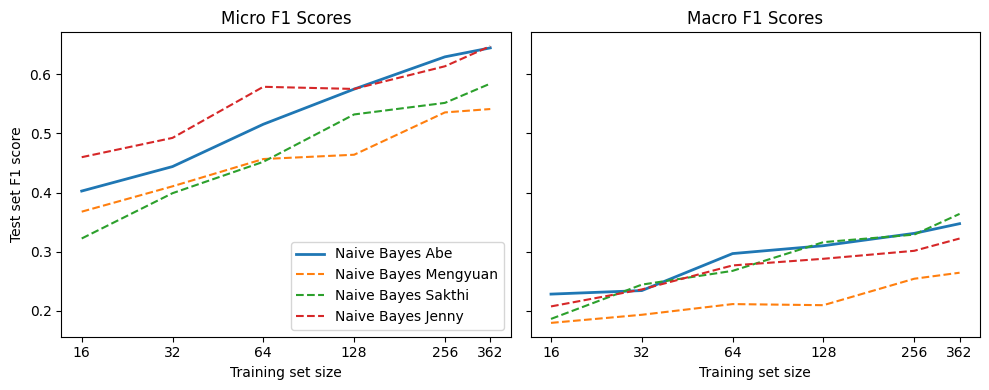

In [24]:
plot_metrics(micro_scores, macro_scores, train_samples_abe, 'Naive Bayes Abe')

## BERT

[cf NLP With Transformers book ch. 9](https://github.com/nlp-with-transformers/notebooks/blob/main/09_few-to-no-labels.ipynb)

In [25]:
import torch
from transformers import (AutoTokenizer, AutoConfig,
                          AutoModelForSequenceClassification)

In [26]:
model_chpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_chpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [27]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

def prepare_dataset(ds):
    ds_enc = ds.map(tokenize, batched=True)  # Prepare DataSetDict
    ds_enc = ds_enc.remove_columns(['labels', 'text'])  # Remove columns we don't need from the encoded dataset
    return ds_enc

# Tokenize and prepare each dataset
ds_enc_abe = prepare_dataset(ds_abe_batch)
ds_enc_mengyuan = prepare_dataset(ds_mengyuan_batch)
ds_enc_sakthi = prepare_dataset(ds_sakthi_batch)
ds_enc_jenny = prepare_dataset(ds_jenny_batch)

Map:   0%|          | 0/361 [00:00<?, ? examples/s]

Map:   0%|          | 0/183 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/183 [00:00<?, ? examples/s]

In [28]:
# Set the format to PyTorch tensors for each dataset
ds_enc_abe.set_format("torch")
ds_enc_mengyuan.set_format("torch")
ds_enc_sakthi.set_format("torch")
ds_enc_jenny.set_format("torch")


In [29]:

# Create a temporary column to hold torch.float label_ids
ds_enc_abe = ds_enc_abe.map(lambda batch: {"label_ids_f": torch.tensor(batch["label_ids"], dtype=torch.float)})
ds_enc_mengyuan = ds_enc_mengyuan.map(lambda batch: {"label_ids_f": torch.tensor(batch["label_ids"], dtype=torch.float)})
ds_enc_sakthi = ds_enc_sakthi.map(lambda batch: {"label_ids_f": torch.tensor(batch["label_ids"], dtype=torch.float)})
ds_enc_jenny = ds_enc_jenny.map(lambda batch: {"label_ids_f": torch.tensor(batch["label_ids"], dtype=torch.float)})

# Remove the old label_ids column
ds_enc_abe = ds_enc_abe.remove_columns("label_ids")
ds_enc_mengyuan = ds_enc_mengyuan.remove_columns("label_ids")
ds_enc_sakthi = ds_enc_sakthi.remove_columns("label_ids")
ds_enc_jenny = ds_enc_jenny.remove_columns("label_ids")

# Rename the temporary column to label_ids
ds_enc_abe = ds_enc_abe.rename_column("label_ids_f", "label_ids")
ds_enc_mengyuan = ds_enc_mengyuan.rename_column("label_ids_f", "label_ids")
ds_enc_sakthi = ds_enc_sakthi.rename_column("label_ids_f", "label_ids")
ds_enc_jenny = ds_enc_jenny.rename_column("label_ids_f", "label_ids")


Map:   0%|          | 0/361 [00:00<?, ? examples/s]

<ipython-input-29-6533999f0c41>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_enc_abe = ds_enc_abe.map(lambda batch: {"label_ids_f": torch.tensor(batch["label_ids"], dtype=torch.float)})


Map:   0%|          | 0/183 [00:00<?, ? examples/s]

Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

<ipython-input-29-6533999f0c41>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_enc_mengyuan = ds_enc_mengyuan.map(lambda batch: {"label_ids_f": torch.tensor(batch["label_ids"], dtype=torch.float)})


Map:   0%|          | 0/181 [00:00<?, ? examples/s]

Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Map:   0%|          | 0/359 [00:00<?, ? examples/s]

<ipython-input-29-6533999f0c41>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_enc_sakthi = ds_enc_sakthi.map(lambda batch: {"label_ids_f": torch.tensor(batch["label_ids"], dtype=torch.float)})


Map:   0%|          | 0/182 [00:00<?, ? examples/s]

Map:   0%|          | 0/184 [00:00<?, ? examples/s]

Map:   0%|          | 0/362 [00:00<?, ? examples/s]

<ipython-input-29-6533999f0c41>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_enc_jenny = ds_enc_jenny.map(lambda batch: {"label_ids_f": torch.tensor(batch["label_ids"], dtype=torch.float)})


Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/183 [00:00<?, ? examples/s]

In [30]:
from transformers import TrainingArguments, Trainer

training_args_fine_tune = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,
    learning_rate=3e-5,
    lr_scheduler_type='constant',
    per_device_train_batch_size=4,
    per_device_eval_batch_size=32,
    weight_decay=0.0,
    evaluation_strategy='epoch',
    save_strategy='epoch',
    logging_strategy='epoch',
    load_best_model_at_end=True,
    metric_for_best_model='micro f1',
    save_total_limit=1,
    log_level='error'
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [31]:
from scipy.special import expit as sigmoid

In [32]:
def compute_metrics(pred):
  y_true = pred.label_ids
  y_pred = sigmoid(pred.predictions)
  y_pred = (y_pred > 0.5).astype(float)
  clf_dict = classification_report(y_true, y_pred, target_names = mlb.classes_, # note this might be an error in the book
                                   zero_division=0, output_dict=True)
  return {
      'micro f1': clf_dict['micro avg']['f1-score'],
      'macro f1': clf_dict['macro avg']['f1-score']
  }

In [33]:
config = AutoConfig.from_pretrained(model_chpt)
config.num_labels = len(mlb.classes_)
config.problem_type = "multi_label_classification"

In [34]:
from transformers import AutoModelForSequenceClassification, Trainer

# Define dataset dictionaries and training slices
datasets = {
    'abe': ds_enc_abe,
    'mengyuan': ds_enc_mengyuan,
    'jenny': ds_enc_jenny,
    'sakthi': ds_enc_sakthi
}

train_slices = {
    'abe': train_slices_abe,
    'mengyuan': train_slices_mengyuan,
    'jenny': train_slices_jenny,
    'sakthi': train_slices_sakthi
}

# Initialize dictionaries to store scores
macro_scores = {
    'BERT - Abe': [],
    'BERT - Mengyuan': [],
    'BERT - Jenny': [],
    'BERT - Sakthi': []
}

micro_scores = {
    'BERT - Abe': [],
    'BERT - Mengyuan': [],
    'BERT - Jenny': [],
    'BERT - Sakthi': []
}

# Iterate over datasets and their corresponding training slices
for name, ds in datasets.items():
    for train_slice in train_slices[name]:
        model = AutoModelForSequenceClassification.from_pretrained(model_chpt, config=config)

        trainer = Trainer(
            model=model,
            args=training_args_fine_tune,
            train_dataset=ds['train'].select(train_slice),
            eval_dataset=ds['validation'],  # Use the validation split here
            compute_metrics=compute_metrics
        )

        trainer.train()

        pred = trainer.predict(ds['test'])

        metrics = compute_metrics(pred)

        # Append metrics to the scores dictionary
        macro_scores[f'BERT - {name.capitalize()}'].append(metrics['macro f1'])
        micro_scores[f'BERT - {name.capitalize()}'].append(metrics['micro f1'])


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.666700,0.621759,0.190909,0.102468
2,0.568700,0.559907,0.070588,0.037037
3,0.515800,0.520479,0.074380,0.042254
4,0.449300,0.477095,0.000000,0.000000
5,0.408400,0.451269,0.130612,0.049383
6,0.381000,0.437884,0.376712,0.118280
7,0.358400,0.426458,0.333333,0.108046
8,0.315900,0.414439,0.438710,0.135797
9,0.285200,0.408053,0.413333,0.131467
10,0.255400,0.398363,0.465839,0.149110


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.676500,0.610062,0.347826,0.155622
2,0.568000,0.533375,0.435530,0.143438
3,0.471300,0.468822,0.193050,0.068871
4,0.418300,0.423964,0.413115,0.130346
5,0.372500,0.406579,0.457831,0.139966
6,0.337400,0.392749,0.464832,0.152653
7,0.286900,0.376563,0.448598,0.170597
8,0.261300,0.390138,0.495775,0.169854
9,0.223300,0.371448,0.475610,0.208539
10,0.200600,0.376943,0.510989,0.208747


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.615500,0.519149,0.409786,0.144516
2,0.459300,0.431894,0.461538,0.123894
3,0.373700,0.389968,0.494048,0.149249
4,0.306900,0.348756,0.539877,0.222016
5,0.253500,0.333337,0.595506,0.290336
6,0.217300,0.325312,0.608939,0.256713
7,0.178000,0.327161,0.621622,0.304479
8,0.150000,0.303268,0.666667,0.368665
9,0.125300,0.300109,0.671958,0.378118
10,0.101100,0.300664,0.682540,0.383333


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.577900,0.461325,0.000000,0.000000
2,0.425700,0.418218,0.548077,0.220508
3,0.346200,0.336438,0.663130,0.299174
4,0.263300,0.298286,0.722513,0.401794
5,0.214100,0.277430,0.741294,0.409867
6,0.175900,0.266458,0.733668,0.405321
7,0.162600,0.268415,0.739241,0.408394
8,0.123600,0.265123,0.741688,0.408323
9,0.094500,0.262809,0.744526,0.426647
10,0.076200,0.277631,0.741463,0.455983


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.488300,0.370413,0.607143,0.259659
2,0.320400,0.311467,0.711779,0.386072
3,0.225700,0.287233,0.737101,0.406494
4,0.182700,0.260426,0.739241,0.451224
5,0.154600,0.259479,0.736842,0.461354
6,0.108000,0.259474,0.758950,0.522157
7,0.087400,0.245710,0.779582,0.604224
8,0.061700,0.246712,0.775982,0.600352
9,0.046200,0.251837,0.784223,0.599433
10,0.037800,0.275617,0.780374,0.571876


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.472400,0.345252,0.630682,0.266131
2,0.292000,0.273023,0.730864,0.398190
3,0.197500,0.248859,0.735219,0.406061
4,0.151100,0.269666,0.751843,0.439998
5,0.103500,0.252760,0.786364,0.535131
6,0.069800,0.230100,0.803695,0.586263
7,0.059600,0.252660,0.797297,0.595533
8,0.046100,0.252172,0.799076,0.621625
9,0.034700,0.281998,0.798186,0.608317
10,0.028800,0.267122,0.791855,0.616269


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.706200,0.650283,0.196429,0.093346
2,0.611200,0.582630,0.357542,0.150721
3,0.520300,0.551622,0.428169,0.104683
4,0.494200,0.479562,0.429851,0.108108
5,0.424300,0.438479,0.228070,0.075362
6,0.391000,0.417315,0.370656,0.109589
7,0.343500,0.403744,0.367816,0.108108
8,0.317200,0.391445,0.251082,0.081921
9,0.288000,0.390814,0.377358,0.109649
10,0.258200,0.378341,0.308943,0.100527


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.666400,0.598632,0.255875,0.110336
2,0.543000,0.523827,0.423077,0.102258
3,0.445200,0.412768,0.307018,0.106507
4,0.364900,0.392954,0.224299,0.095395
5,0.325100,0.395341,0.455385,0.116352
6,0.289800,0.348447,0.401674,0.146885
7,0.247200,0.351653,0.506667,0.157814
8,0.208900,0.327767,0.498168,0.168415
9,0.177600,0.337372,0.515464,0.174331
10,0.165200,0.315578,0.580205,0.248182


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.602800,0.501394,0.456954,0.128667
2,0.425900,0.390157,0.308370,0.102339
3,0.345600,0.348534,0.507246,0.149068
4,0.284700,0.329631,0.513889,0.153140
5,0.239100,0.319680,0.588997,0.229167
6,0.209400,0.296905,0.612245,0.270159
7,0.187800,0.293233,0.589474,0.267825
8,0.164000,0.290808,0.623377,0.307677
9,0.138800,0.297760,0.645963,0.314888
10,0.121700,0.278629,0.653595,0.337008


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.547400,0.416008,0.455598,0.134703
2,0.391400,0.351835,0.476923,0.166483
3,0.291700,0.322803,0.560000,0.198631
4,0.220100,0.280526,0.668770,0.349651
5,0.173500,0.283131,0.687117,0.367748
6,0.162100,0.280076,0.676923,0.356233
7,0.131300,0.293983,0.664596,0.338148
8,0.107000,0.288271,0.662539,0.344658
9,0.080100,0.289320,0.680115,0.358759
10,0.067200,0.307925,0.695402,0.366934


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.470000,0.352286,0.417671,0.191692
2,0.283400,0.286579,0.670623,0.346835
3,0.196800,0.284879,0.720000,0.381258
4,0.154900,0.269320,0.727273,0.389089
5,0.127300,0.286047,0.720461,0.413623
6,0.104400,0.284134,0.727273,0.441808
7,0.079200,0.308950,0.713483,0.422755
8,0.066200,0.285042,0.733138,0.437088
9,0.050100,0.296647,0.718391,0.456354
10,0.036000,0.307521,0.720000,0.461757


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.423800,0.324109,0.613982,0.250216
2,0.248300,0.296102,0.707246,0.374938
3,0.172400,0.279274,0.707246,0.413655
4,0.139900,0.317164,0.688047,0.362047
5,0.109800,0.279408,0.746439,0.467881
6,0.081300,0.343746,0.719101,0.456390
7,0.061400,0.331010,0.717087,0.436312
8,0.044700,0.323356,0.715847,0.462609
9,0.031400,0.366177,0.700565,0.492220
10,0.025600,0.366895,0.713896,0.518268


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.664400,0.643684,0.262799,0.156590
2,0.616100,0.580593,0.407035,0.171384
3,0.531000,0.514077,0.404692,0.160635
4,0.457300,0.454954,0.422819,0.135683
5,0.390000,0.420918,0.423208,0.116761
6,0.340800,0.400648,0.466877,0.122720
7,0.310100,0.384320,0.354717,0.105145
8,0.286600,0.375567,0.453074,0.120898
9,0.280600,0.367219,0.456954,0.128172
10,0.239000,0.356809,0.421818,0.137634


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.663600,0.590959,0.377724,0.146559
2,0.528600,0.490779,0.437126,0.175676
3,0.438000,0.446371,0.473239,0.117155
4,0.365000,0.378827,0.431655,0.123457
5,0.309000,0.358247,0.387597,0.142070
6,0.263400,0.354120,0.501548,0.151868
7,0.235700,0.322489,0.575080,0.213026
8,0.210500,0.315634,0.561056,0.201616
9,0.178200,0.311873,0.556634,0.206237
10,0.158300,0.321262,0.599407,0.219798


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.611700,0.510360,0.355401,0.150069
2,0.438500,0.400120,0.381679,0.114155
3,0.348000,0.351074,0.524138,0.191468
4,0.263500,0.321609,0.610272,0.243130
5,0.211100,0.307283,0.601881,0.238459
6,0.168600,0.291180,0.646707,0.286079
7,0.148200,0.288021,0.666667,0.322739
8,0.133800,0.296700,0.668622,0.331381
9,0.112400,0.300649,0.687151,0.371867
10,0.103600,0.315041,0.668508,0.333220


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.550200,0.411152,0.446667,0.121377
2,0.363600,0.342418,0.643478,0.255290
3,0.254100,0.319535,0.650000,0.254391
4,0.179900,0.305333,0.718499,0.391495
5,0.144000,0.297728,0.728767,0.394413
6,0.123400,0.292605,0.686981,0.374629
7,0.098100,0.340644,0.712766,0.384456
8,0.080900,0.296538,0.706849,0.379924
9,0.068000,0.321438,0.711957,0.381701
10,0.059700,0.311656,0.724868,0.421347


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.456700,0.347412,0.597561,0.222588
2,0.279100,0.300146,0.719346,0.379346
3,0.185200,0.285241,0.704607,0.384166
4,0.146400,0.286879,0.736000,0.393015
5,0.119700,0.279726,0.702703,0.441462
6,0.093400,0.267059,0.717172,0.432882
7,0.081300,0.265107,0.729730,0.390655
8,0.063900,0.290255,0.726316,0.443267
9,0.048000,0.317513,0.715026,0.473535
10,0.042700,0.307203,0.743455,0.444968


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.438200,0.330273,0.586895,0.223771
2,0.258600,0.303006,0.724409,0.391854
3,0.172600,0.254548,0.733696,0.396482
4,0.142500,0.274006,0.739362,0.440251
5,0.116100,0.289964,0.726316,0.442159
6,0.089700,0.276073,0.750656,0.471839
7,0.072600,0.281375,0.737705,0.470095
8,0.049100,0.287834,0.738220,0.471378
9,0.036600,0.309206,0.768041,0.561868
10,0.026100,0.319286,0.748052,0.543545


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.682800,0.664441,0.177474,0.088396
2,0.650800,0.609383,0.187192,0.081743
3,0.584900,0.562188,0.403458,0.140205
4,0.524000,0.506569,0.260223,0.089059
5,0.489600,0.481622,0.281690,0.091324
6,0.439500,0.491072,0.406250,0.105691
7,0.425300,0.443083,0.391304,0.114130
8,0.381400,0.429414,0.384858,0.113594
9,0.358500,0.443550,0.418231,0.110638
10,0.327300,0.406071,0.361842,0.110442


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.675700,0.619872,0.198198,0.105652
2,0.575500,0.537912,0.360248,0.117536
3,0.498700,0.497350,0.421918,0.113069
4,0.427000,0.423899,0.377104,0.117400
5,0.379800,0.407123,0.412698,0.122411
6,0.331600,0.386854,0.400000,0.120155
7,0.298800,0.391408,0.440476,0.133620
8,0.269000,0.363231,0.392027,0.133861
9,0.244300,0.362448,0.442424,0.152028
10,0.221900,0.349597,0.489676,0.240123


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.628900,0.571646,0.412533,0.107483
2,0.497700,0.443000,0.239382,0.085399
3,0.411000,0.398709,0.361011,0.119904
4,0.331500,0.362894,0.444444,0.149876
5,0.293500,0.349375,0.471299,0.171678
6,0.236900,0.346222,0.528926,0.263804
7,0.209100,0.329725,0.569061,0.300590
8,0.177500,0.323277,0.562674,0.309478
9,0.143800,0.367663,0.552846,0.321715
10,0.126400,0.330380,0.586022,0.323147


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.568800,0.449854,0.246032,0.090643
2,0.416200,0.392380,0.351648,0.118519
3,0.336300,0.348167,0.490909,0.212268
4,0.240100,0.319831,0.622108,0.384230
5,0.195200,0.334421,0.603675,0.361747
6,0.154600,0.301582,0.670077,0.452567
7,0.117400,0.333427,0.614583,0.401192
8,0.084400,0.330156,0.613402,0.408959
9,0.072000,0.319622,0.659950,0.460872
10,0.056300,0.334176,0.644501,0.451290


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.495200,0.374214,0.432990,0.137255
2,0.316500,0.364879,0.527473,0.250357
3,0.237900,0.365584,0.586118,0.338913
4,0.173500,0.291047,0.693267,0.462364
5,0.122800,0.322016,0.678049,0.454602
6,0.084500,0.283270,0.707617,0.486575
7,0.062200,0.299933,0.707617,0.480764
8,0.043800,0.321583,0.712919,0.512946
9,0.032400,0.353121,0.704156,0.478026
10,0.026800,0.333708,0.731591,0.529745


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.438500,0.335021,0.498534,0.188537
2,0.279800,0.316910,0.633245,0.389146
3,0.208000,0.275720,0.663158,0.438124
4,0.144500,0.266989,0.734491,0.497518
5,0.104400,0.288266,0.718447,0.488624
6,0.075800,0.304602,0.725490,0.506978
7,0.057300,0.312808,0.717073,0.506824
8,0.040100,0.351280,0.716981,0.502805
9,0.031500,0.342121,0.731591,0.529454
10,0.021200,0.367105,0.721839,0.531368


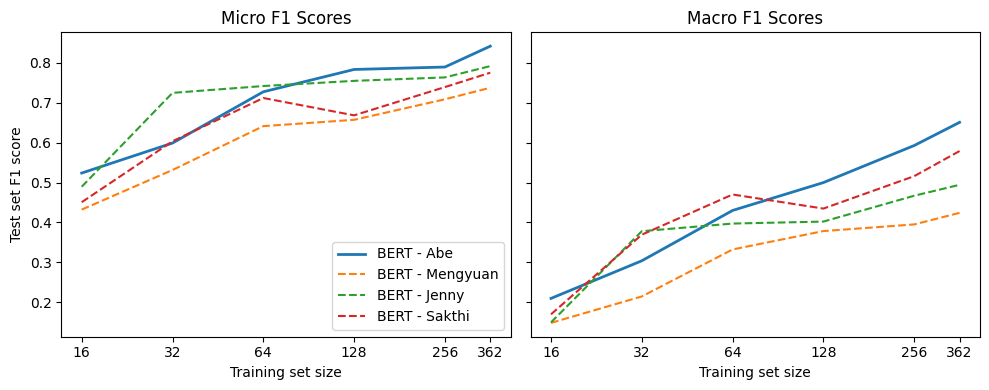

In [35]:
plot_metrics(micro_scores, macro_scores, train_samples_abe, 'BERT - Abe')